## Minimal Vanilla Neural Network Implementation

In [1]:
import abc
import enum

import numpy as np
from tqdm.notebook import tqdm

import nnfs
from nnfs.datasets import sine_data, spiral_data

nnfs.init()

In [2]:
#! /usr/bin/env python3.10

"""
Neural Network Layer implementations.
`numpy` is required. -> https://numpy.org/
Compatible with python3.10+.
Mahyar@Mahyar24.com, Sat 23 Apr 2022.
"""

class Layer:
    """
    Neural Network Layer.
    """

    def __init__(
        self,
        num_inputs: int,
        num_neurons: int,
        *,
        w_l1: float = 0.0,
        b_l1: float = 0.0,
        w_l2: float = 0.0,
        b_l2: float = 0.0,
    ) -> None:
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.weights = np.random.randn(num_inputs, num_neurons) * 0.01
        self.biases = np.zeros((1, num_neurons))

        # Regularization
        self.w_l1 = w_l1
        self.b_l1 = b_l1
        self.w_l2 = w_l2
        self.b_l2 = b_l2

        self.inputs = None
        self.output = None
        self.dw = None
        self.db = None
        self.derivatives = None

    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass of the layer.
        Forward: `W . X + b`
        """
        assert len(inputs.shape) == 2, f"Inputs ({inputs.shape=}) must be a 2D array."
        assert (
            inputs.shape[1] == self.num_inputs
        ), f"Inputs ({inputs.shape=}) must have the same number of columns as the layer. ({self.num_inputs=})"

        # Remember the inputs for the backward pass.
        self.inputs = inputs
        self.output = inputs @ self.weights + self.biases

    def backward(self, derivatives: np.ndarray) -> None:
        """
        Backward pass of the layer.
        Backward: `dW = inputs.T . derivatives, db = derivatives.T.sum(), derivatives = derivatives @ W.T`
        """
        self.dw = self.inputs.T @ derivatives
        self.db = derivatives.sum(axis=0, keepdims=True)
        self.derivatives = derivatives @ self.weights.T

        # L1 Regularization
        if self.w_l1 > 0:
            d_w_l1 = np.ones_like(self.weights)
            d_w_l1[self.weights < 0] = -1
            self.dw += self.w_l1 * d_w_l1
        if self.b_l1 > 0:
            d_b_l1 = np.ones_like(self.biases)
            d_b_l1[self.biases < 0] = -1
            self.db += self.b_l1 * d_b_l1
        # L2 Regularization
        if self.w_l2 > 0:
            d_w_l2 = 2 * self.w_l2 * self.weights
            self.dw += d_w_l2
        if self.b_l2 > 0:
            d_b_l2 = 2 * self.b_l2 * self.biases
            self.db += d_b_l2


class Dropout:
    """
    Dropout layer.
    """

    def __init__(self, drop_rate: float) -> None:
        self.rate = 1 - drop_rate

        self.output = None
        self.derivatives = None
        self.mask = None

    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass of the layer.
        Change the values of the inputs to 0 with a probability of `self.rate`.
        """
        # Normalizing the mask to keep the same scale with the inputs.
        self.mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        # Element-wise multiplication of the inputs and the mask.
        self.output = inputs * self.mask

    def backward(self, derivatives):
        """
        Backward pass of the layer.
        """
        self.derivatives = derivatives * self.mask


In [3]:
#! /usr/bin/env python3.10

"""
All necessary Activation functions.
`numpy` is required. -> https://numpy.org/
Compatible with python3.10+.
Mahyar@Mahyar24.com, Sat 23 Apr 2022.
"""

class Activation(metaclass=abc.ABCMeta):
    """
    Abstract base class for activation functions.
    `forward` and `backward` methods must be implemented.
    """

    def __init__(self) -> None:
        self.inputs = None
        self.outputs = None
        self.derivatives = None

    @abc.abstractmethod
    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass of the activation function.
        """
        pass

    @abc.abstractmethod
    def backward(self, derivatives: np.ndarray) -> None:
        """
        Backward pass of the activation function.
        """
        pass


class ReLU(Activation):
    """
    Rectified Linear Unit activation function.
    Forward: `x > 0` -> `x` otherwise `0`
    Backward: `x > 0` -> `1` otherwise `0`
    """

    def __init__(self) -> None:
        super().__init__()

    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass of the activation function.
        Forward: `x > 0` -> `x` otherwise `0`
        """
        # Remember the inputs for the backward pass
        self.inputs = inputs
        # Apply the activation function. ReLU is applied element-wise.
        self.output = np.maximum(0, inputs)

    def backward(self, derivatives: np.ndarray) -> None:
        """
        Backward pass of the activation function.
        Backward: `x > 0` -> `1` otherwise `0`
        """
        self.derivatives = derivatives.copy()
        # Apply the derivatives of the activation function.
        self.derivatives[self.inputs < 0] = 0


class LeakyReLU(Activation):
    """
    Leaky Rectified Linear Unit activation function.
    Forward: `x > 0` -> `x` otherwise `x * negative_slope`
    Backward: `x > 0` -> `1` otherwise `negative_slope`
    """

    def __init__(self, negative_slope: float = 0.01) -> None:
        super().__init__()
        self.negative_slope = negative_slope

    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass of the activation function.
        Forward: `x > 0` -> `x` otherwise `x * negative_slope`
        """
        # Remember the inputs for the backward pass
        self.inputs = inputs
        # Apply the activation function. LeakyReLU is applied element-wise.
        self.output = np.where(inputs > 0, inputs, self.negative_slope * inputs)

    def backward(self, derivatives: np.ndarray) -> None:
        """
        Backward pass of the activation function.
        Backward: `x > 0` -> `1` otherwise `negative_slope`
        """
        self.derivatives = derivatives.copy()
        # Apply the derivatives of the activation function.
        self.derivatives[self.inputs < 0] *= self.negative_slope


class Sigmoid(Activation):
    """
    Sigmoid activation function.
    Forward: `1 / (1 + exp(-x))`
    Backward: `sig(x) * (1 - sig(x))`
    """

    def __init__(self) -> None:
        super().__init__()

    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass of the activation function.
        Forward: `1 / (1 + exp(-x))`
        """
        self.output = 1 / (1 + np.exp(-inputs))

    def backward(self, derivatives: np.ndarray) -> None:
        """
        Backward pass of the activation function.
        Backward: `sig(x) * (1 - sig(x))`
        """
        self.derivatives = derivatives * self.output * (1 - self.output)


class Linear(Activation):
    """
    Linear activation function, for regression.
    Forward: `x`
    Backward: `1`
    """

    def __init__(self) -> None:
        super().__init__()

    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass of the activation function.
        Forward: `x`
        """
        self.output = inputs

    def backward(self, derivatives: np.ndarray) -> None:
        """
        Backward pass of the activation function.
        Backward: `1`
        """
        self.derivatives = derivatives.copy()


class Softmax(Activation):
    """
    Softmax activation function.
    Forward: `exp(x) / sum(exp(x))`
    Backward: `softmax(i) * (Kronecker_delta(i, j) - softmax(j))`
    """

    def __init__(self) -> None:
        super().__init__()

    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass of the activation function.
        Forward: `exp(x) / sum(exp(x))`
        """
        exp_inputs = np.exp(
            inputs - np.max(inputs, axis=1, keepdims=True)
        )  # Normalizing for preventing overflow.
        self.output = exp_inputs / np.sum(exp_inputs, axis=1, keepdims=True)

    def backward(self, derivatives: np.ndarray) -> None:
        """
        Backward pass of the activation function.
        Backward: `softmax(i) * (Kronecker_delta(i, j) - softmax(j))`
        """
        self.derivatives = np.empty_like(derivatives)
        # For each example, for each class, we compute the derivative.
        # `for` loop makes it slow.
        for i, (output, derivatives) in enumerate(zip(self.output, derivatives)):
            output = output.reshape(-1, 1)
            jacobian = np.diagflat(output) - (output @ output.T)
            self.derivatives[i] = jacobian @ derivatives


class TanH(Activation):
    """
    Hyperbolic tangent activation function.
    Forward: `tanh(x)`
    Backward: `1 - tanh(x)**2`
    """

    def __init__(self) -> None:
        super().__init__()

    def forward(self, inputs: np.ndarray) -> None:
        """
        Forward pass of the activation function.
        Forward: `tanh(x)`
        """
        # Apply the activation function. ReLU is applied element-wise.
        self.output = np.tanh(inputs)

    def backward(self, derivatives: np.ndarray) -> None:
        """
        Backward pass of the activation function.
        Backward: `1 - tanh(x)**2`
        """
        self.derivatives = derivatives.copy()
        # Apply the derivatives of the activation function.
        self.derivatives *= 1 - self.output**2


In [4]:
#! /usr/bin/env python3.10

"""
All necessary Loss metrics and implementations.
`numpy` is required. -> https://numpy.org/
Compatible with python3.10+.
Mahyar@Mahyar24.com, Sat 23 Apr 2022.
"""

def check_shapes(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Check if shapes of y_true and y_pred are appropriate.
    """
    assert len(y_true.shape) == 1, f"y_true ({y_true.shape=}) must be a 1D array."
    assert len(y_pred.shape) == 2, f"y_pred ({y_pred.shape=}) must be a 2D array."
    assert (
        y_true.shape[0] == y_pred.shape[0]
    ), f"y_true ({y_true.shape=}) and y_pred ({y_pred.shape=}) must have the same number of samples."


@enum.unique
class LossType(enum.Enum):
    """
    Types of loss functions.
    """

    REGRESSION = "REGRESSION"
    CLASSIFICATION = "CLASSIFICATION"


class Loss(metaclass=abc.ABCMeta):
    """
    Abstract base class for all Loss implementations.
    """

    def __int__(self) -> None:
        self.derivatives = None

    @abc.abstractmethod
    def calculate(self, y_true: np.ndarray, y_pred: np.ndarray):
        """
        Calculate the loss value.
        """
        check_shapes(y_true, y_pred)

    @abc.abstractmethod
    def backward(self, y_true: np.ndarray, y_pred: np.ndarray) -> None:
        """
        Backward pass of the loss function.
        """
        check_shapes(y_true, y_pred)

    @staticmethod
    def regularization(layer: Layer) -> float:
        """
        Calculate the regularization loss for a layer.
        """
        regularization_loss = 0.0

        # L1
        if layer.w_l1 > 0.0:
            regularization_loss += np.abs(layer.w_l1 * layer.weights).sum()
        if layer.b_l1 > 0.0:
            regularization_loss += np.abs(layer.b_l1 * layer.biases).sum()
        # L2
        if layer.w_l2 > 0.0:
            regularization_loss += layer.w_l2 * (layer.weights**2).sum()
        if layer.b_l2 > 0.0:
            regularization_loss += layer.b_l2 * (layer.biases**2).sum()

        return regularization_loss


class CategoricalLoss(Loss):
    """
    Categorical cross-entropy loss.
    """

    loss_type = LossType.CLASSIFICATION

    def __init__(self) -> None:
        super().__init__()

    def calculate(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Calculate the loss value.
        loss: `-log(correct_prediction) / batch_size`
        """
        check_shapes(y_true, y_pred)

        # Clip the predictions to avoid NaN.
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        correct_confidences = y_pred_clipped[range(y_true.shape[0]), y_true]
        loss = (-np.log(correct_confidences)).mean()
        return loss

    def backward(self, y_true: np.ndarray, y_pred: np.ndarray) -> None:
        """
        Backward pass of the loss function.
        Backward: `-(y_true / y_pred)`
        """
        check_shapes(y_true, y_pred)

        one_hot_y_true = np.eye(y_pred.shape[1])[y_true]
        self.derivatives = -one_hot_y_true / y_pred
        # Normalizing the derivatives.
        self.derivatives /= y_true.shape[0]


class BinaryLoss(Loss):
    """
    Binary cross-entropy loss.
    """

    loss_type = LossType.CLASSIFICATION

    def __init__(self) -> None:
        super().__init__()

    def calculate(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Calculate the loss value.
        loss: `-y_true * log(y_pred) - (1 - y_true) * log(1 - y_pred) / batch_size`
        """
        check_shapes(y_true, y_pred)

        # Clip the predictions to avoid NaN.
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Reshaping y_true to match y_pred.
        y_true = y_true.copy().reshape(-1, 1)

        losses = -(
            y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped)
        )
        return losses.mean(axis=-1).mean()

    def backward(self, y_true: np.ndarray, y_pred: np.ndarray) -> None:
        """
        Backward pass of the loss function.
        Backward: `-((y_true / y_pred) - (1 - y_true) / (1 - y_pred)) / number_of_classes`
        """
        check_shapes(y_true, y_pred)

        # Clip the predictions to avoid NaN.
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Reshaping y_true to match y_pred.
        y_true = y_true.copy().reshape(-1, 1)

        self.derivatives = (
            -((y_true / y_pred_clipped) - ((1 - y_true) / (1 - y_pred_clipped)))
            / y_pred_clipped.shape[1]
        )
        # Normalizing the derivatives.
        self.derivatives /= y_true.shape[0]


class MSELoss(Loss):
    """
    Mean squared error loss.
    """

    loss_type = LossType.REGRESSION

    def __init__(self) -> None:
        super().__init__()

    def calculate(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Calculate the loss value.
        loss: `(y_true - y_pred) ** 2 / batch_size`
        """
        check_shapes(y_true, y_pred)

        # Reshaping y_true to match y_pred.
        y_true = y_true.copy().reshape(-1, 1)

        losses = (y_true - y_pred) ** 2
        return losses.mean()

    def backward(self, y_true: np.ndarray, y_pred: np.ndarray) -> None:
        """
        Backward pass of the loss function.
        Backward: `-2 * (y_true - y_pred)`
        """
        check_shapes(y_true, y_pred)

        # Reshaping y_true to match y_pred.
        y_true = y_true.copy().reshape(-1, 1)

        self.derivatives = -2 * (y_true - y_pred)
        # Normalizing the derivatives.
        self.derivatives /= y_true.shape[0]


class SoftmaxLoss:
    """
    Softmax activation layer combined with categorical cross-entropy loss.
    The derivatives of combining these two layers is computationally a lot cheaper than processing each one separately;
    so we merge them into one layer.
    """

    loss_type = LossType.CLASSIFICATION

    def __init__(self) -> None:
        self.output = None
        self.derivatives = None
        self.activation = Softmax()
        self.loss = CategoricalLoss()
        self.regularization = self.loss.regularization

    def forward(self, *, inputs: np.ndarray) -> None:
        """
        Forwarding the inputs to activation layer.
        """
        self.activation.forward(inputs)
        self.output = self.activation.output

    def calculate(self, y_true: np.ndarray, *_, **__) -> float:
        """
        Calculate the loss value. y_pred is same as `self.output` but for sake of consistency,
        we will accept *args and **kwargs as same but ignore them.
        This method must be used after a forward pass.
        """
        return self.loss.calculate(y_true, self.output)

    def backward(self, y_true: np.ndarray, y_pred: np.ndarray) -> None:
        """
        Backward pass of the combined activation and loss functions.
        Backward: `y_pred - y_true`
        """
        check_shapes(y_true, y_pred)

        self.derivatives = y_pred.copy()
        # y_true == 1, so we need to subtract 1 from y_pred.
        self.derivatives[range(y_true.shape[0]), y_true] -= 1
        # Normalizing the derivatives.
        self.derivatives /= y_true.shape[0]


In [5]:
#! /usr/bin/env python3.10

"""
Implementation of various optimizers.
`numpy` is required. -> https://numpy.org/
Compatible with python3.10+.
Mahyar@Mahyar24.com, Sat 23 Apr 2022.
"""

class Optimizer(metaclass=abc.ABCMeta):
    """
    Abstract base class for optimizers.
    """

    @abc.abstractmethod
    def pre_update(self) -> None:
        """
        Pre-Update parameters.
        """
        pass

    @abc.abstractmethod
    def update(self, layer: Layer) -> None:
        """
        Update parameters.
        """
        pass

    @abc.abstractmethod
    def post_update(self) -> None:
        """
        Post-Update parameters.
        """
        pass


class Momentum(Optimizer):
    def __init__(
        self, learning_rate: float = 0.01, decay: float = 1e-5, beta: float = 0.1
    ) -> None:
        self.learning_rate = learning_rate
        self.decay = decay
        self.beta = beta
        self.iterations = 0
        self.current_learning_rate = learning_rate

    def pre_update(self) -> None:
        """
        Lower the learning rate.
        """
        if self.decay:
            self.current_learning_rate = self.learning_rate / (
                1 + (self.decay * self.iterations)
            )

    def update(self, layer: Layer) -> None:
        """
        Update parameters.
        """
        if not hasattr(layer, "v_dw"):
            layer.v_dw = np.zeros_like(layer.dw)
            layer.v_db = np.zeros_like(layer.db)

        layer.v_dw = self.beta * layer.v_dw + (1 - self.beta) * layer.dw
        layer.v_db = self.beta * layer.v_db + (1 - self.beta) * layer.db

        layer.weights -= self.current_learning_rate * layer.v_dw
        layer.biases -= self.current_learning_rate * layer.v_db

    def post_update(self) -> None:
        """
        Increase the iteration counter.
        """
        self.iterations += 1


class Adam(Optimizer):
    def __init__(
        self,
        learning_rate: float = 0.01,
        decay: float = 1e-5,
        beta_1: float = 0.9,
        beta_2: float = 0.999,
        eps: float = 1e-7,
    ) -> None:
        self.learning_rate = learning_rate
        self.decay = decay
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = eps
        self.iterations = 0
        self.current_learning_rate = learning_rate

    def pre_update(self) -> None:
        """
        Lower the learning rate.
        """
        if self.decay:
            self.current_learning_rate = self.learning_rate / (
                1 + (self.decay * self.iterations)
            )

    def update(self, layer: Layer) -> None:
        """
        Update parameters.
        """
        if not hasattr(layer, "v_dw"):
            layer.v_dw = np.zeros_like(layer.dw)
            layer.v_db = np.zeros_like(layer.db)
            layer.s_dw = np.zeros_like(layer.dw)
            layer.s_db = np.zeros_like(layer.db)

        layer.v_dw = self.beta_1 * layer.v_dw + (1 - self.beta_1) * layer.dw
        v_dw_corrected = layer.v_dw / (1 - (self.beta_1 ** (self.iterations + 1)))

        layer.v_db = self.beta_1 * layer.v_db + (1 - self.beta_1) * layer.db
        v_db_corrected = layer.v_db / (1 - (self.beta_1 ** (self.iterations + 1)))

        layer.s_dw = self.beta_2 * layer.s_dw + (1 - self.beta_2) * (layer.dw**2)
        s_dw_corrected = layer.s_dw / (1 - (self.beta_2 ** (self.iterations + 1)))

        layer.s_db = self.beta_2 * layer.s_db + (1 - self.beta_2) * (layer.db**2)
        s_db_corrected = layer.s_db / (1 - (self.beta_2 ** (self.iterations + 1)))

        w_update = v_dw_corrected / (np.sqrt(s_dw_corrected) + self.eps)
        b_update = v_db_corrected / (np.sqrt(s_db_corrected) + self.eps)

        layer.weights -= self.current_learning_rate * w_update
        layer.biases -= self.current_learning_rate * b_update

    def post_update(self) -> None:
        """
        Increase the iteration counter.
        """
        self.iterations += 1


In [6]:
#! /usr/bin/env python3.10

"""
Implementation of various metrics.
`numpy` is required. -> https://numpy.org/
Compatible with python3.10+.
Mahyar@Mahyar24.com, Sat 23 Apr 2022.
"""

class Metric(metaclass=abc.ABCMeta):
    """
    Abstract class for metrics.
    """

    @staticmethod
    def check_shapes(y_true: np.ndarray, y_pred: np.ndarray) -> None:
        assert len(y_true.shape) == 1, f"y ({y_true.shape=}) must be a 1D array."
        assert len(y_pred.shape) == 1, f"y_pred ({y_pred.shape=}) must be a 1D array."
        assert (
            y_true.shape[0] == y_pred.shape[0]
        ), f"y_true ({y_true.shape=}) and y_pred ({y_pred.shape=}) must have the same number of samples."

    @staticmethod
    @abc.abstractmethod
    def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Calculate the metric.
        """
        pass


class Accuracy(Metric):
    """
    Accuracy metric for classification problems.
    """

    @staticmethod
    def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Calculate the accuracy of classification.
        """
        Metric.check_shapes(y_true, y_pred)

        return (y_pred == y_true).mean()


class ExplainedVariance(Metric):
    """
    Explained variance metric for regression problems.
    """

    @staticmethod
    def evaluate(y_true, y_pred: np.ndarray) -> float:
        """
        1 - (var(y - y_pred) / var(y))
        """
        Metric.check_shapes(y_true, y_pred)

        return 1 - (np.var(y_true - y_pred) / np.var(y_true))


In [7]:
#! /usr/bin/env python3.10

"""
Implementation of Model.
`numpy` is required. -> https://numpy.org/
Compatible with python3.10+.
Mahyar@Mahyar24.com, Sat 23 Apr 2022.
"""

from __future__ import annotations

import copy
import pickle
from statistics import fmean
from typing import Iterator, Optional, Union

class Model:
    """
    Neural Network Model
    """

    def __init__(
        self, *, loss: Union[Loss, SoftmaxLoss], optimizer: Optimizer, metric: Metric
    ) -> None:
        self.layers = []
        if isinstance(loss, Loss) or isinstance(loss, SoftmaxLoss):
            self.loss = loss
        else:
            raise ValueError("loss must be an instance of Loss or SoftmaxLoss.")
        if isinstance(optimizer, Optimizer):
            self.optimizer = optimizer
        else:
            raise ValueError("optimizer must be an instance of Optimizer.")
        if isinstance(metric, Metric):
            self.metric = metric
        else:
            raise ValueError("metric must be an instance of Metric.")
        self.data_ = {}

    def add(self, layer: Union[Layer, Activation]) -> None:
        """
        Add a layer to the model.
        """
        assert isinstance(layer, Layer) or isinstance(
            layer, Activation
        ), "layer must be an instance of Layer or Activation."

        self.layers.append(layer)

    @staticmethod
    def check_dimensions(X: np.ndarray, y: Optional[np.ndarray] = None) -> None:
        assert len(X.shape) == 2, f"X must be a 2D array. Got {X.shape}"
        if y is not None:
            assert len(y.shape) == 1, f"y must be a 1D array. Got {y.shape}"
            assert (
                X.shape[0] == y.shape[0]
            ), f"X and y must have the same number of rows. {X.shape[0]=} != {y.shape[0]=}"

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Forward propagation.
        """
        for i, layer in enumerate(self.layers):
            if i == 0:
                layer.forward(X)
            else:
                layer.forward(self.layers[i - 1].output)

        output = self.layers[-1].output
        # SoftmaxLoss is an edge case.
        if isinstance(self.loss, SoftmaxLoss):
            self.loss.forward(inputs=output)
            output = self.loss.output

        return output

    def backward(self, y: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        Backward propagation.
        """
        self.loss.backward(y, y_pred)
        for i, layer in enumerate(reversed(self.layers)):
            if i == 0:
                layer.backward(self.loss.derivatives)
            else:
                layer.backward(self.layers[-i].derivatives)

        return self.layers[0].derivatives

    def optimize(self) -> None:
        """
        Optimize the neural layers of the model.
        """
        self.optimizer.pre_update()
        # Reversing just for demonstration purposes.
        for layer in reversed(self.layers):
            if isinstance(layer, Layer):
                self.optimizer.update(layer)
        self.optimizer.post_update()

    def record_data(
        self,
        X: np.ndarray,
        y: np.ndarray,
        lr: list[float],
        accuracies: list[float],
        losses: list[float],
        regularization_losses: list[float],
    ) -> None:
        """
        Record data. This method should only use adder a forward propagation.
        """
        lr.append(self.optimizer.current_learning_rate)
        accuracies.append(self.metric.evaluate(y, self.predict(X)))
        losses.append(self.loss.calculate(y, self.layers[-1].output))
        regularization_losses.append(
            sum(
                self.loss.regularization(layer)
                for layer in self.layers
                if isinstance(layer, Layer)
            )
        )

    @staticmethod
    def shuffle_data(X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Shuffle data.
        """
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        return X[indices], y[indices]

    def generate_batch(
        self,
        X: np.ndarray,
        y: np.ndarray,
        batch_size: Optional[int] = None,
        shuffle: bool = True,
    ) -> Iterator[tuple[np.ndarray, np.ndarray]]:
        """
        Generate a batch of data.
        """
        if batch_size is not None:
            assert (
                batch_size <= X.shape[0]
            ), f"{batch_size=} must be smaller than {X.shape[0]=}"
        else:
            # If batch_size is None, use the whole data.
            batch_size = X.shape[0]

        if shuffle:
            X, y = self.shuffle_data(X, y)

        for i in range(0, X.shape[0], batch_size):
            yield X[i : i + batch_size], y[i : i + batch_size]

    def fit(
        self,
        X,
        y,
        epochs=1_000,
        batch_size: Optional[int] = None,
        verbose: bool = False,
        record_epoch: int = 1,
        shuffle: bool = True,
    ) -> None:
        """
        Fit the model.
        """
        self.check_dimensions(X, y)

        # Adding progress bar with tqdm.
        for epoch in (
            bar := tqdm(
                range(1, epochs + 1),
                desc="Iterating ...",
                total=epochs,
                bar_format="{desc}: {bar} {n_fmt}/{total_fmt} {percentage:3.0f}%",
            )
        ):
            # Initiate some data for recording for each epoch.
            lr: list[float] = []
            accuracies: list[float] = []
            losses: list[float] = []
            regularization_losses: list[float] = []

            # Optimize for a mini-batch.
            for X_batch, y_batch in self.generate_batch(X, y, batch_size, shuffle):
                # Forward propagation
                output = self.forward(X_batch)
                # Record data
                self.record_data(
                    X_batch, y_batch, lr, accuracies, losses, regularization_losses
                )
                # Backward propagation
                self.backward(y_batch, output)
                # Optimize
                self.optimize()

            # Record data
            if epoch % record_epoch == 0:
                self.data_[epoch] = {
                    "lr": fmean(lr),
                    "accuracies": fmean(accuracies),
                    "losses": fmean(losses),
                    "regularization_losses": fmean(regularization_losses),
                }
                # Print info
                if verbose:
                    # Print info in formatted manner.
                    info_str = " ".join(
                        [f"{k}: {v:.4f}" for k, v in self.data_[epoch].items()]
                    )
                    bar.set_description(info_str)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predict probabilities.
        """
        self.check_dimensions(X)

        if self.loss.loss_type == LossType.REGRESSION:
            raise NotImplementedError(
                "For prediction regression problem, use `predict` method."
            )

        output = self.forward(X)

        # Sigmoid
        if isinstance(self.layers[-1], Sigmoid) and not isinstance(
            self.loss, SoftmaxLoss
        ):
            return np.hstack((1 - output, output))
        # Softmax
        else:
            if output.shape[1] == 1:  # Using Softmax inappropriately.
                return output.reshape(-1)
            return output

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the output of the model.
        """
        self.check_dimensions(X)

        if self.loss.loss_type == LossType.CLASSIFICATION:
            return self.predict_proba(X).argmax(axis=1)
        return self.forward(X).reshape(-1)

    @staticmethod
    def load(path: str) -> Model:
        """
        Load the model.
        """
        with open(path, "rb") as f:
            return pickle.load(f)

    def save(self, path: str, purge_training_records: bool = True) -> None:
        """
        Save the model.
        """
        # Purge training records.
        if purge_training_records:
            pickling_model = copy.deepcopy(self)
            pickling_model.data_ = {}
        else:
            pickling_model = self

        with open(path, "wb") as f:
            pickle.dump(pickling_model, f, protocol=pickle.HIGHEST_PROTOCOL)


In [25]:
#! /usr/bin/env python3.10

"""
Different cases of using the nnfs.
`numpy` is required. -> https://numpy.org/
Compatible with python3.10+.
Mahyar@Mahyar24.com, Sat 23 Apr 2022.
"""

def classification_SoftmaxLoss(X_train, y_train, X_test, y_test):
    """
    Classification model with SoftmaxLoss and Adam optimizer.
    3 classes and 2 features.
    """
    model = Model(loss=SoftmaxLoss(), optimizer=Adam(), metric=Accuracy())
    model.add(Layer(2, 16))
    model.add(LeakyReLU())
    model.add(Layer(16, 64))
    model.add(LeakyReLU())
    model.add(Layer(64, 3))
    model.fit(X_train, y_train, verbose=True, epochs=100, record_epoch=1, batch_size=400)
    validation_accuracy = Accuracy.evaluate(y_test, model.predict(X_test))
    print(f"Validation Accuracy: {validation_accuracy:.2%}")
    return model


def classification_Softmax_Categorical(X_train, y_train, X_test, y_test):
    """
    Classification model with Softmax Activation and CategoricalLoss (separately) and Adam optimizer.
    3 classes and 2 features.
    """
    model = Model(loss=CategoricalLoss(), optimizer=Adam(), metric=Accuracy())
    model.add(Layer(2, 64, w_l2=5e-3, b_l2=5e-3))
    model.add(ReLU())
    model.add(Layer(64, 3))
    model.add(Softmax())
    model.fit(X_train, y_train, verbose=True, epochs=1_000, record_epoch=1)
    validation_accuracy = Accuracy.evaluate(y_test, model.predict(X_test))
    print(f"Validation Accuracy: {validation_accuracy:.2%}")
    return model


def classification_Sigmoid_BinaryLoss(X_train, y_train, X_test, y_test):
    """
    Classification model with Sigmoid Activation and BinaryLoss and Adam optimizer.
    2 classes and 2 features.
    """
    model = Model(loss=BinaryLoss(), optimizer=Adam(), metric=Accuracy())
    model.add(Layer(2, 64, w_l2=5e-4, b_l2=5e-4))
    model.add(ReLU())
    model.add(Layer(64, 1))
    model.add(Sigmoid())
    model.fit(X_train, y_train, verbose=True, epochs=1_000, record_epoch=1)
    validation_accuracy = Accuracy.evaluate(y_test, model.predict(X_test))
    print(f"Validation Accuracy: {validation_accuracy:.2%}")
    return model


def regression_Linear_MSE(X_train, y_train, X_test, y_test):
    """
    Regression model with Linear activation and MSE loss and Adam optimizer.
    1 feature.
    """
    model = Model(loss=MSELoss(), optimizer=Adam(), metric=ExplainedVariance())
    model.add(Layer(1, 64, w_l2=5e-4, b_l2=5e-4))
    model.add(ReLU())
    model.add(Layer(64, 64))
    model.add(ReLU())
    model.add(Layer(64, 1))
    model.add(Linear())
    model.fit(X_train, y_train, verbose=True, epochs=1_000, record_epoch=1)
    validation_accuracy = ExplainedVariance.evaluate(y_test, model.predict(X_test))
    print(f"Validation Accuracy: {validation_accuracy:.2%}")
    return model


def classification_SoftmaxLoss_Dropout(X_train, y_train, X_test, y_test):
    """
    Classification model with SoftmaxLoss and Adam optimizer.
    3 classes and 2 features with Dropout.
    """
    model = Model(loss=SoftmaxLoss(), optimizer=Adam(), metric=Accuracy())
    model.add(Layer(2, 512))
    model.add(ReLU())
    model.add(Dropout(0.05))
    model.add(Layer(512, 3))
    model.fit(X_train, y_train, verbose=True, epochs=1_000, record_epoch=1)
    validation_accuracy = Accuracy.evaluate(y_test, model.predict(X_test))
    print(f"Validation Accuracy: {validation_accuracy:.2%}")
    return model


def regression_Linear_MSE_Dropout(X_train, y_train, X_test, y_test):
    """
    Regression model with Linear activation and MSE loss and Adam optimizer.
    1 feature with Dropout.
    """
    model = Model(loss=MSELoss(), optimizer=Adam(), metric=ExplainedVariance())
    model.add(Layer(1, 512))
    model.add(ReLU())
    model.add(Dropout(0.05))
    model.add(Layer(512, 512))
    model.add(ReLU())
    model.add(Layer(512, 1))
    model.add(Linear())
    model.fit(X_train, y_train, verbose=True, epochs=200, record_epoch=1)
    validation_accuracy = ExplainedVariance.evaluate(y_test, model.predict(X_test))
    print(f"Validation Accuracy: {validation_accuracy:.2%}")
    return model


In [35]:
# Make data
(X_train_clf_3, y_train_clf_3), (X_test_clf_3, y_test_clf_3) = spiral_data(
    samples=10_000, classes=3
), spiral_data(samples=1_000, classes=3)
(X_train_clf_2, y_train_clf_2), (X_test_clf_2, y_test_clf_2) = spiral_data(
    samples=500, classes=2
), spiral_data(samples=50, classes=2)
X_reg_1, y_reg_1 = sine_data(3100)
y_reg_1 = y_reg_1.reshape(-1)
X_train_reg_1 = X_reg_1[:3000, :].copy()
y_train_reg_1 = y_reg_1[:3000].copy()
X_test_reg_1 = X_reg_1[3000:3100, :].copy()
y_test_reg_1 = y_reg_1[3000:3100].copy()

In [36]:
# Test.
print('classification_SoftmaxLoss: ')
clf = classification_SoftmaxLoss(X_train_clf_3, y_train_clf_3, X_test_clf_3, y_test_clf_3)

# print('classification_Softmax_Categorical: ')
# classification_Softmax_Categorical(
#     X_train_clf_3, y_train_clf_3, X_test_clf_3, y_test_clf_3
# )

# print('classification_Sigmoid_BinaryLoss: ')
# classification_Sigmoid_BinaryLoss(
#     X_train_clf_2, y_train_clf_2, X_test_clf_2, y_test_clf_2
# )

# print('regression_Linear_MSE: ')
# regression_Linear_MSE(X_train_reg_1, y_train_reg_1, X_test_reg_1, y_test_reg_1)

# print('classification_SoftmaxLoss_Dropout: ')
# classification_SoftmaxLoss_Dropout(
#     X_train_clf_3, y_train_clf_3, X_test_clf_3, y_test_clf_3
# )

# print('regression_Linear_MSE_Dropout: ')
# regression_Linear_MSE_Dropout(
#     X_train_reg_1, y_train_reg_1, X_test_reg_1, y_test_reg_1
# )

classification_SoftmaxLoss: 


Iterating ...:            0/100   0%

Validation Accuracy: 90.13%


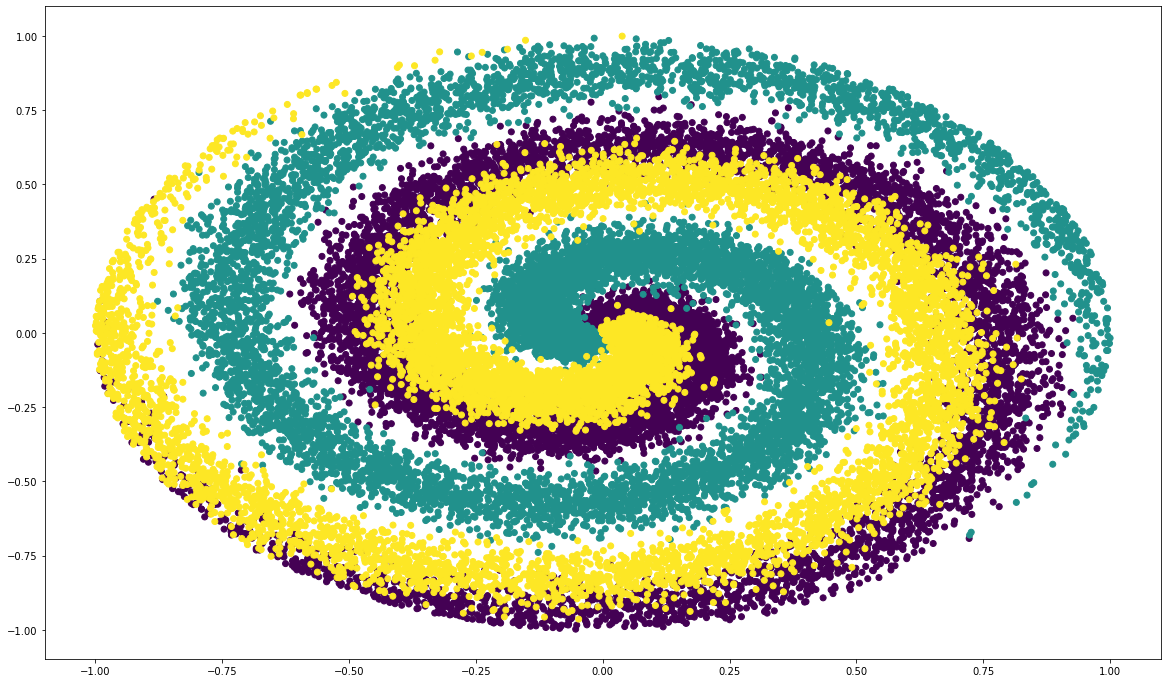

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.scatter(X_train_clf_3[:, 0], X_train_clf_3[:, 1], c=y_train_clf_3);

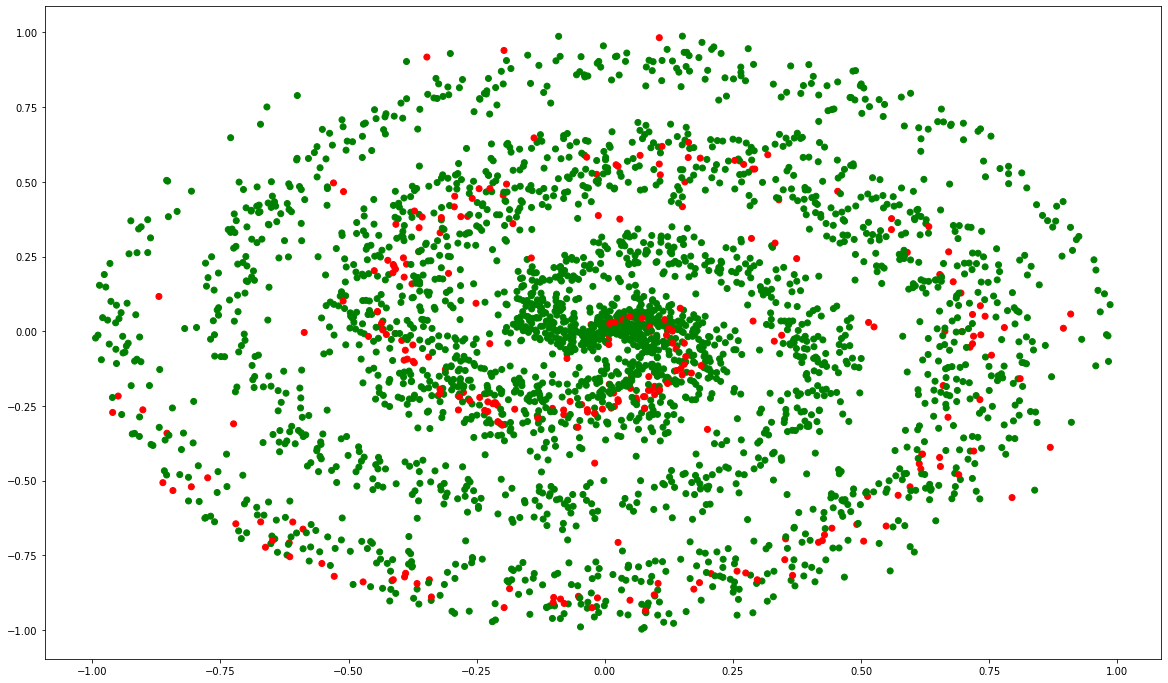

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.scatter(X_test_clf_3[:, 0], X_test_clf_3[:, 1], c=np.where(y_test_clf_3 == clf.predict(X_test_clf_3), 'green', 'red'));